In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import sys

sys.path.append("..")

import Models.OWID as owid
import Models.SIRD as sird
import Models.GradDescModels as gdm
import Models.process as process

import scipy.optimize as opt

def getIndex(A, item):
    index = 0
    while(index < len(A) and A[index] != item):
        index = index + 1
    
    if(index == len(A)):
        return -1 #doesn't exists
    return index #found

import csv
import platform
import os.path
def getCountryDates(countryName, filePathOver=""):
    fileName = "../../Data/Country Policy Data/" #mac file address
    if(filePathOver!=""): #override was set
        fileName = filePathOver
    #pathc="../Data/Covid Tracking State Data/"
    if platform.system() == "Windows":
        fileName.replace("/", "\\")
    fileName = fileName+countryName + ".csv"
    
    if(not os.path.exists(fileName)):
        return []
    
    csvFile = open(fileName, newline='', encoding='UTF-8')
    rd = csv.reader(csvFile, delimiter=',') #reader
    data=[] #the data of all countries
    for lv in rd: #generating the data matrix
        data.append(lv)

    labels = np.array(data[0]) #get the labels
    data = data[1:] #remove the header
    data = np.array(data) #convert to np array for simplicity
    
    return data[:,0].transpose() #just the dates

####################################################################



21.290788627826473
18.981811949074835
19.430956637247352
7.0896848847298255


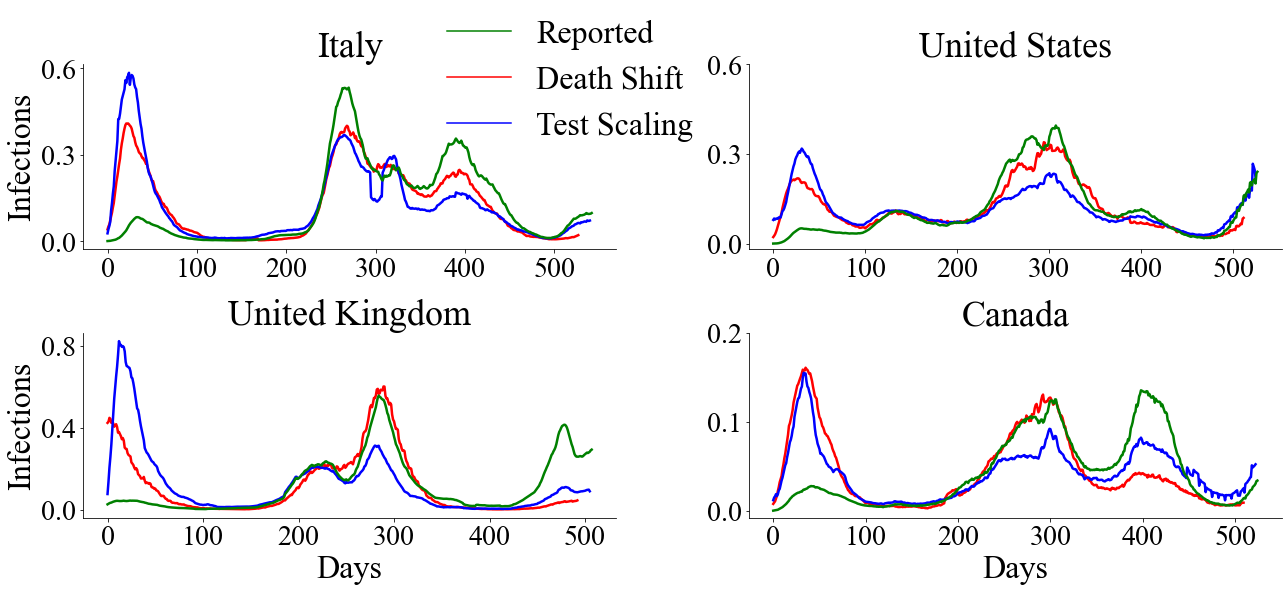

In [2]:
import matplotlib.lines
plt.rcParams['font.family'] = "Times New Roman"

fig, ax = plt.subplots(2,2, figsize=(18,8))

def getIScaleData(countryName):
    dates, I, R, D, V = owid.LoadCountryNormalDeaths(countryName, shiftAmount=15) #deaths
    dates2, I2, R2, D2, V2 = owid.LoadCountryNormal(countryName) #tests
    dates3, [I3, D3, pop] = owid.LoadCountry(countryName, selectColumns=[4, 7, 46]) #normal
    
    I = I + R + D
    scale = 2500*(D3[-1]/pop[0])/I[-1]
    I = scale*I
    R = scale*R
    D = scale*D
    I = I - R - D
    
    I2 = I2 + R2 + D2
    scale = 2500*(D3[-1]/pop[0])/I2[-1]
    print(scale)
    I2 = scale*I2
    R2 = scale*R2
    D2 = scale*D2
    I2 = I2 - R2 - D2
    
    R3 = process.getRecov(I3, D3)
    scale =  2500*(D3[-1]/pop[0])/I3[-1]
    I3 = scale*I3
    R3 = scale*R3
    D3 = scale*D3
    I3 = I3 - D3 - R3

    startDate = dates[0]
    if(dates2[0] > dates[0]):
        startDate = dates2[0]

    I = I[getIndex(dates, startDate):]
    I2 = I2[getIndex(dates2,startDate):]
    I3 = I3[getIndex(dates3,startDate):]

    dates = dates[getIndex(dates, startDate):]
    dates2 = dates2[getIndex(dates2,startDate):]
    dates3 = dates3[getIndex(dates3,startDate):]
    
    return I3, I, I2 #reported, death method, test method

I1, I2, I3 = getIScaleData("Italy")
ax[0][0].plot(I2, color="red", linewidth=2.5)
ax[0][0].plot(I3, color="blue", linewidth=2.5)
ax[0][0].plot(I1, color="green", linewidth=2.5)
ax[0][0].set_title("Italy", fontsize=36)

I1, I2, I3 = getIScaleData("United States")
ax[0][1].plot(I2, color="red", linewidth=2.5)
ax[0][1].plot(I3, color="blue", linewidth=2.5)
ax[0][1].plot(I1, color="green", linewidth=2.5)
ax[0][1].set_title("United States", fontsize=36)

I1, I2, I3 = getIScaleData("United Kingdom")
ax[1][0].plot(I2, color="red", linewidth=2.5)
ax[1][0].plot(I3, color="blue", linewidth=2.5)
ax[1][0].plot(I1, color="green", linewidth=2.5)
ax[1][0].set_title("United Kingdom", fontsize=36)

I1, I2, I3 = getIScaleData("Canada")
ax[1][1].plot(I2, color="red", linewidth=2.5)
ax[1][1].plot(I3, color="blue", linewidth=2.5)
ax[1][1].plot(I1, color="green", linewidth=2.5)
ax[1][1].set_title("Canada", fontsize=36)

line1 = matplotlib.lines.Line2D([0.5,1], [0,0], color="green")
line2 = matplotlib.lines.Line2D([0,1], [0,0], color="red")
line3 = matplotlib.lines.Line2D([0,1], [0,0], color="blue")

#fig.suptitle("True Infection Estimations of Different Methods", fontsize=30)
fig.legend([line1, line2, line3], ["Reported", "Death Shift", "Test Scaling"], 
           
           fontsize=32, loc="upper right", bbox_to_anchor=(.56,1.05), frameon=False)

ax[1][0].set_xlabel("Days", fontsize=32)
ax[1][1].set_xlabel("Days", fontsize=32)

ax[0][0].set_ylabel("Infections", fontsize=32)
ax[1][0].set_ylabel("Infections", fontsize=32)

#print(dates[0], dates2[0], dates3[0])

consts = [len(I1), I1[0], max(I1), 0]


from matplotlib.ticker import MaxNLocator

for i in range(0,2):
    for j in range(0,2):
        #ax[i][j].yaxis.set_major_locator(MaxNLocator(3)) 
        ax[i][j].tick_params(axis='x', labelsize=28)
        ax[i][j].tick_params(axis='y', labelsize=28)
        
        ax[i][j].spines['top'].set_visible(False)
        ax[i][j].spines['right'].set_visible(False)
        
        #ax[i][j].grid()

ax[0][0].set_yticks([0, .3, .6])
ax[0][1].set_yticks([0, .3, .6])
ax[1][0].set_yticks([0, .4, .8])
ax[1][1].set_yticks([0, .1, .2])

plt.tight_layout()

fig.subplots_adjust(hspace=.45, wspace = .25)


#plt.savefig("../../Feedback Conference Paper/DifferentMethods.eps", bbox_inches = 'tight')

In [3]:
#testing all fonts
#import matplotlib.font_manager
##flist = matplotlib.font_manager.get_fontconfig_fonts()
#names = [matplotlib.font_manager.FontProperties(fname=fname).get_name() for fname in flist]
#print(names)

In [2]:
def diffSameSize(A):
    B = np.zeros(len(A))
    B[0] = 0 #assume previous day was same as start day
    B[1:] = A[1:] - A[0:-1]
    
    return B

import csv
import platform

def loadCAData():
    fileName = "../../Data/California Test Data/CA.csv" #mac file address
    #pathc="../Data/Covid Tracking State Data/"
    if platform.system() == "Windows":
        fileName.replace("/", "\\")

    csvFile = open(fileName, newline='', encoding='UTF-8')
    rd = csv.reader(csvFile, delimiter=',') #reader
    data=[] #the data of all countries
    for lv in rd: #generating the data matrix
        data.append(lv)

    labels = np.array(data[0]) #get the labels
    data = data[1:] #remove the header
    data = np.array(data) #convert to np array for simplicity

    for i in range(len(data)):
        for j in range(len(data[i])):
            if(data[i,j] == ''): #empty cell, convert to 0
                data[i,j] = '0'

    dates = data[:,np.where(labels == "Dates")[0][0]] #the dates column
    dead = data[:,np.where(labels == "Deaths")[0][0]].astype(np.float) #total deaths
    infected = data[:,np.where(labels == "Infected")[0][0]].astype(np.float) #total infections
    tested = data[:,np.where(labels == "Tested")[0][0]].astype(np.float) #total tests

    population = float(data[0,np.where(labels == "Population")[0][0]])

    #scale by population
    I = infected/population
    D = dead/population
    
    #there are a couple bad reported days in CA, skip over them.
    sD = 0 #startDate, first day with over .001 infection
    while(I[sD] < .0001):
        sD = sD+1
    dates = dates[sD:]
    D = D[sD:]
    I = I[sD:]
    tested = tested[sD:]

    newI = diffSameSize(I)
    newTests = diffSameSize(tested)

    modNewI = process.scaleNewInfections(newI, newTests) #scale by tests

    I = process.reverseDiff(modNewI) #aggregate
    I = I * (.22/(max(I))) #adjust so it matches max = .1, this is arbitrary
    
    R = process.getRecov(I, D)
    I = I - R - D #change to current infections, instead of total

    sD = 0 #startDate, first day with over .001 infection
    while(I[sD] < .001):
        sD = sD+1

    return dates[sD:],I[sD:],R[sD:],D[sD:] #current infections, recoveries, deaths

## California

0 New best error:  1.4149010421873992e-05
1 New best error:  1.3953322153013886e-05
2 New best error:  1.3789398329662646e-05


..\Models\GradDescModels.py:50: RuntimeWarning: invalid value encountered in double_scalars
  diffA = (beta[0]/ (1 + (beta[1]*I[t])**(beta[2]) ) )*A[t] - gamma0*A[t]


5 New best error:  1.37490837235355e-05
6 New best error:  1.358138925809838e-05
12 New best error:  9.884661368625454e-06
30 New best error:  9.747656191349835e-06


..\Models\GradDescModels.py:164: RuntimeWarning: invalid value encountered in double_scalars
  diffA = (b0/ (1 + (currB1*I[t])**(b2) ) )*A[t] - gamma0*A[t]


0 New best error:  2.7007801105218906e-06
25 New best error:  2.46155869759091e-06
49 New best error:  2.439214836863178e-06
0 New best error:  6.473671527848469e-06


..\Models\GradDescModels.py:280: RuntimeWarning: invalid value encountered in double_scalars
  diffA = (b0/ (1 + (b1*I[t])**(currB2) ) )*A[t] - gamma0*A[t]


2 New best error:  5.408582128161757e-06
3 New best error:  3.0409058402663465e-06
5 New best error:  2.4671639425462004e-06
73 New best error:  2.2695364890845336e-06
85 New best error:  2.0701791846822533e-06


..\Models\GradDescModels.py:393: RuntimeWarning: invalid value encountered in double_scalars
  diffA = (b0/ (1 + (b1*I[t])**(b2) ) )*A[t] - currG0*A[t]


0 New best error:  1.3264314294610606e-05
2 New best error:  6.567184511716797e-06
3 New best error:  2.2673056674087122e-06
6 New best error:  1.986504023450464e-06
[3.29069269e-03 2.92199912e-05 5.33691177e-01 7.59330503e-02
 4.69707194e-02 8.25108742e-01 8.00299219e+01 9.35247220e+01
 7.39983532e+01 1.17733121e+02 4.11383222e+01 2.86303510e+02
 1.98441115e+02 1.26696014e+02 8.87445675e-01]
[2.91290028e-03 4.65388605e-04 6.52825259e-01 1.66192861e-01
 4.33208059e-02 7.58889208e-01 4.29021239e+01 5.51254102e-01
 1.31556336e+00 1.42532923e+00 1.08603638e+00 3.49423671e+00
 5.70632627e-01 1.05634356e+00 1.00348492e+00]
[3.85206736e-03 2.00340381e-03 5.67050106e-01 2.84284182e-01
 2.44489092e-01 3.20620071e-01 1.36135559e-01 3.62914271e-01
 3.27939488e-01 3.36841770e-01 1.22372878e-01 3.62453136e-02
 3.92870497e-01 1.16704471e+02 2.29943137e+00]
[2.16959803e-04 1.83971698e-03 2.37648584e-01 1.29452993e-01
 6.93472385e-03 1.70242429e+00 4.07510885e+02 5.48310026e+00]
['2020-03-19' '2020-0

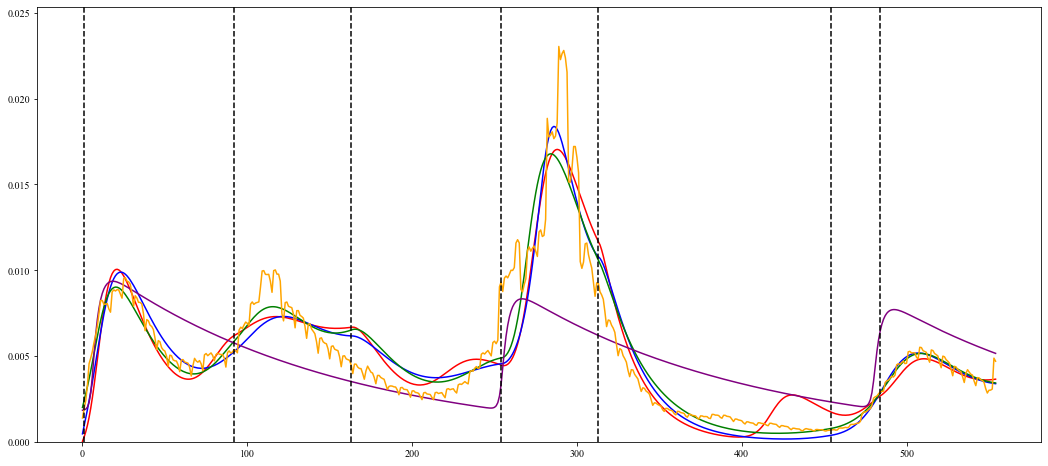

In [114]:
dates, I, R, D = loadCAData()
consts = [len(I), I[0], max(I), 0]

measureDates = getCountryDates("California Closure Data", filePathOver="../../Data/California Test Data/")
measureIndexes = []
for measure in measureDates:
    measureIndexes.append(getIndex(dates, measure))
measureIndexesAlt = measureIndexes.copy()
measureIndexesAlt.append(len(I))
    
consts = [len(I), I[0], max(I), measureIndexesAlt]
californiaParams = gdm.getParams(I, consts, randomIterCount=80, method = "Nelder-Mead")
californiaParamsB1 = gdm.getParamsB1(I, consts, randomIterCount=100, method = "Nelder-Mead") #with b1
californiaParamsB2 = gdm.getParamsB2(I, consts, randomIterCount=100, method = "Nelder-Mead") #with b2
californiaParamsG0 = gdm.getParamsG0(I, consts, randomIterCount=100, method = "Nelder-Mead") #with b2

fig,ax = plt.subplots(figsize=(18,8))
ax.plot(gdm.simFuncB1(californiaParamsB1, consts), color="red")
ax.plot(gdm.simFuncB2(californiaParamsB2, consts), color="blue")
ax.plot(gdm.simFuncG0(californiaParamsG0, consts), color="green")
ax.plot(gdm.simFunc(californiaParams, consts), color="purple")
ax.plot(I, color="orange")
ax.set_ylim([0, max(I)*1.1])

print(californiaParamsB1)
print(californiaParamsB2)
print(californiaParamsG0)
print(californiaParams)


measureDates = getCountryDates("California Closure Data", filePathOver="../../Data/California Test Data/")
print(measureDates)
for measure in measureDates:
    if(getIndex(dates,measure) != -1):
            plt.axvline(x=getIndex(dates, measure), color="black", linestyle='--')

## UK

..\Models\GradDescModels.py:50: RuntimeWarning: invalid value encountered in double_scalars
  diffA = (beta[0]/ (1 + (beta[1]*I[t])**(beta[2]) ) )*A[t] - gamma0*A[t]


0 New best error:  2.568966104606767e-05
1 New best error:  1.8818154415532778e-05
12 New best error:  1.2677406711426452e-05
30 New best error:  1.2468774035595557e-05


..\Models\GradDescModels.py:164: RuntimeWarning: invalid value encountered in double_scalars
  diffA = (b0/ (1 + (currB1*I[t])**(b2) ) )*A[t] - gamma0*A[t]


0 New best error:  4.4867209678805097e-05
2 New best error:  1.8154328171024016e-05
12 New best error:  1.6224826440573493e-05
13 New best error:  1.331702418265345e-05
22 New best error:  9.566775623326421e-06
38 New best error:  9.350244278021302e-06


..\Models\GradDescModels.py:280: RuntimeWarning: invalid value encountered in double_scalars
  diffA = (b0/ (1 + (b1*I[t])**(currB2) ) )*A[t] - gamma0*A[t]


0 New best error:  1.0957095095745054e-05
2 New best error:  8.691430023538605e-06
11 New best error:  6.993655823012556e-06
16 New best error:  5.576015737778842e-06
18 New best error:  4.456828711981725e-06
23 New best error:  4.433206101610169e-06
25 New best error:  3.940025941137968e-06


..\Models\GradDescModels.py:393: RuntimeWarning: invalid value encountered in double_scalars
  diffA = (b0/ (1 + (b1*I[t])**(b2) ) )*A[t] - currG0*A[t]


0 New best error:  1.592883842435127e-05
6 New best error:  1.4152103892064445e-05


..\Models\GradDescModels.py:393: RuntimeWarning: overflow encountered in double_scalars
  diffA = (b0/ (1 + (b1*I[t])**(b2) ) )*A[t] - currG0*A[t]


26 New best error:  1.3414127042555292e-05
36 New best error:  8.552259991233397e-06
[ 1.26408962e-02  4.66621275e-04  5.18425687e-01  2.50370672e-01
  7.30063935e-02  7.21621289e-01 -2.00017513e+02  1.85577117e+01
  5.52515137e+01  1.54408404e+02  3.35756604e+01  6.15411361e+01
  6.64078271e+01  1.64233164e+02  1.03704661e+00]
[ 9.02847017e-03  1.14177721e-08  1.08516013e-01  5.74058228e-01
  4.81660512e-02  1.92162113e-01  9.70799265e+01 -2.51561870e+00
  1.30938447e+01  3.27861930e-01  4.12931791e-01  3.63159176e+00
 -8.94231987e-01 -7.15847441e-01  5.33930897e-01]
[ 4.53125245e-02  3.36282408e-03 -8.10300300e-01  1.76656166e-01
  2.85814949e-01  2.83592241e-02 -3.95948671e-01  8.74380584e-02
  8.57834415e-02  4.66263591e-02  1.53114153e-01  4.08909716e-02
  6.56183101e-02  3.95475840e+00  8.24610285e+00]
[1.71834752e-02 3.69734250e-03 2.82512445e-01 3.11924989e-01
 3.90489031e-02 3.35000375e-01 3.29657627e+01 9.20582845e-01]


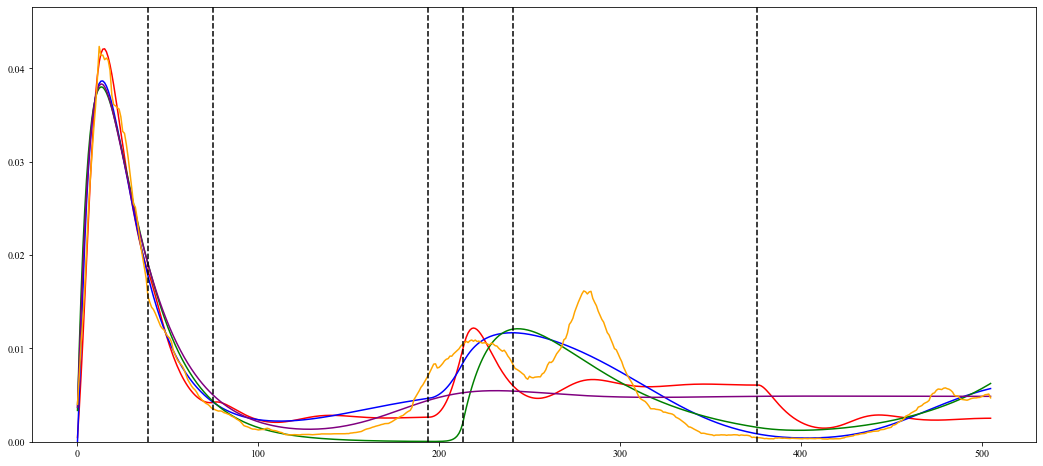

In [13]:
dates, I, R, D, V = owid.LoadCountryNormal("United Kingdom")

measureDates = getCountryDates("United Kingdom")
measureIndexes = []
for measure in measureDates:
    measureIndexes.append(getIndex(dates, measure))
measureIndexesAlt = measureIndexes.copy()
measureIndexesAlt.append(len(I))

consts = [len(I), I[0], max(I), measureIndexesAlt]

ukParams = gdm.getParams(I, consts, randomIterCount=40, method = "Nelder-Mead")

ukParamsB1 = gdm.getParamsB1(I, consts, randomIterCount=40, method = "Nelder-Mead") #with b1
ukParamsB2 = gdm.getParamsB2(I, consts, randomIterCount=40, method = "Nelder-Mead") #with b2
ukParamsG0 = gdm.getParamsG0(I, consts, randomIterCount=40, method = "Nelder-Mead") #with b2

fig,ax = plt.subplots(figsize=(18,8))
ax.plot(gdm.simFuncB1(ukParamsB1, consts), color="red")
ax.plot(gdm.simFuncB2(ukParamsB2, consts), color="blue")
ax.plot(gdm.simFuncG0(ukParamsG0, consts), color="green")
ax.plot(gdm.simFunc(ukParams, consts), color="purple")
ax.plot(I, color="orange")
ax.set_ylim([0, max(I)*1.1])

print(ukParamsB1)
print(ukParamsB2)
print(ukParamsG0)
print(ukParams)

for measure in measureDates:
    if(getIndex(dates,measure) != -1):
            plt.axvline(x=getIndex(dates, measure), color="black", linestyle='--')

## Italy

..\Models\GradDescModels.py:50: RuntimeWarning: invalid value encountered in double_scalars
  diffA = (beta[0]/ (1 + (beta[1]*I[t])**(beta[2]) ) )*A[t] - gamma0*A[t]


0 New best error:  2.0447257419225475e-05
5 New best error:  1.9134324540269367e-05
6 New best error:  1.8077822933822967e-05
13 New best error:  1.3886331215534875e-05


..\Models\GradDescModels.py:164: RuntimeWarning: invalid value encountered in double_scalars
  diffA = (b0/ (1 + (currB1*I[t])**(b2) ) )*A[t] - gamma0*A[t]


0 New best error:  1.9570467686674098e-05
1 New best error:  1.845198821861533e-05
9 New best error:  1.635253969085437e-05
20 New best error:  1.607472878438135e-05
27 New best error:  1.543390736772716e-05
34 New best error:  1.5346590735696737e-05
35 New best error:  8.435783221249309e-06
59 New best error:  7.598244773537239e-06


..\Models\GradDescModels.py:280: RuntimeWarning: invalid value encountered in double_scalars
  diffA = (b0/ (1 + (b1*I[t])**(currB2) ) )*A[t] - gamma0*A[t]


0 New best error:  2.4336742446263813e-05
1 New best error:  2.040692284215347e-05
2 New best error:  6.965643429539237e-06
30 New best error:  5.366454025632332e-06
53 New best error:  4.786119107483256e-06
0 New best error:  3.8568061715372613e-05


..\Models\GradDescModels.py:393: RuntimeWarning: invalid value encountered in double_scalars
  diffA = (b0/ (1 + (b1*I[t])**(b2) ) )*A[t] - currG0*A[t]


1 New best error:  3.760366417460719e-05
2 New best error:  1.5733605459507268e-05
3 New best error:  3.660214628238571e-06
19 New best error:  3.266335779176137e-06
41 New best error:  3.166845870563443e-06
[6.62754824e-03 6.20182560e-14 3.33693793e-01 3.45537555e-01
 2.13978002e-02 4.51412439e-01 5.53270264e+01 5.53460261e+01
 8.50465436e-02 7.87953475e-01 1.75966547e-01]
[ 2.83210414e-03  3.22940650e-04  1.64409013e+00  6.91273069e-03
  1.05789424e-01  3.32654334e+00  9.62673370e+00  1.81201587e-01
 -6.84327540e-02  2.10664345e-03 -1.30026235e-02]
[0.00373177 0.00300593 0.25537529 0.41790356 0.26827561 0.30721873
 0.09325627 0.04633727 0.30490327 1.23037883 0.79095969]
[5.44632541e-03 9.88058501e-04 2.44311590e-01 4.54482499e-01
 2.38196176e-02 2.84293094e-01 6.82340045e+01 2.17289832e+00]


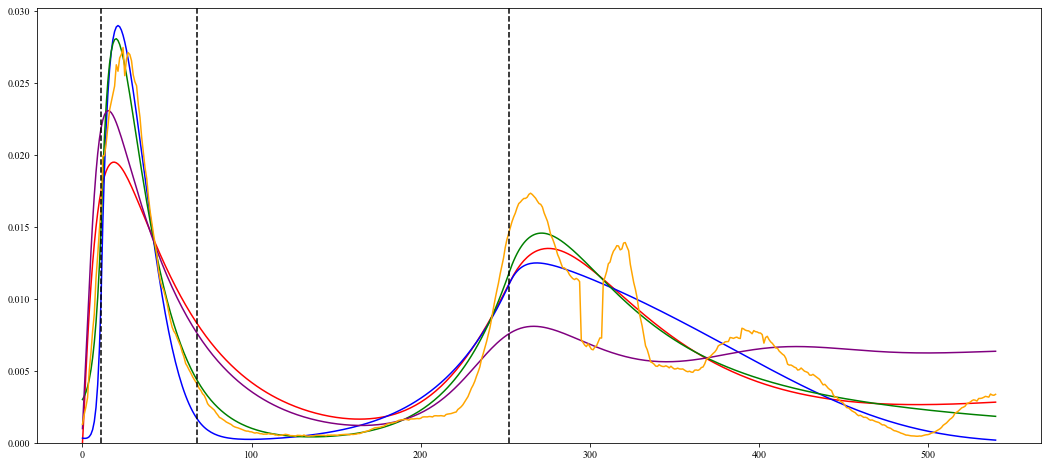

In [18]:
dates, I, R, D, V = owid.LoadCountryNormal("Italy")

measureDates = getCountryDates("Italy")
measureIndexes = []
for measure in measureDates:
    measureIndexes.append(getIndex(dates, measure))
measureIndexesAlt = measureIndexes.copy()
measureIndexesAlt.append(len(I))

consts = [len(I), I[0], max(I), measureIndexesAlt]

itParams = gdm.getParams(I, consts, randomIterCount=80, method = "Nelder-Mead")

itParamsB1 = gdm.getParamsB1(I, consts, randomIterCount=80, method = "Nelder-Mead") #with b1
itParamsB2 = gdm.getParamsB2(I, consts, randomIterCount=80, method = "Nelder-Mead") #with b2
itParamsG0 = gdm.getParamsG0(I, consts, randomIterCount=80, method = "Nelder-Mead") #with b2

fig,ax = plt.subplots(figsize=(18,8))
ax.plot(gdm.simFuncB1(itParamsB1, consts), color="red")
ax.plot(gdm.simFuncB2(itParamsB2, consts), color="blue")
ax.plot(gdm.simFuncG0(itParamsG0, consts), color="green")
ax.plot(gdm.simFunc(itParams, consts), color="purple")
ax.plot(I, color="orange")
ax.set_ylim([0, max(I)*1.1])

print(itParamsB1)
print(itParamsB2)
print(itParamsG0)
print(itParams)

for measure in measureDates:
    if(getIndex(dates,measure) != -1):
            plt.axvline(x=getIndex(dates, measure), color="black", linestyle='--')

## Australia

0 New best error:  9.272208032819533e-05
1 New best error:  7.177820581119734e-05


..\Models\GradDescModels.py:50: RuntimeWarning: invalid value encountered in double_scalars
  diffA = (beta[0]/ (1 + (beta[1]*I[t])**(beta[2]) ) )*A[t] - gamma0*A[t]


7 New best error:  7.159663706204667e-05
8 New best error:  5.665875501281203e-05
42 New best error:  5.650774978222102e-05
46 New best error:  4.650977777208386e-05
49 New best error:  4.5568909032499856e-05
0 New best error:  4.6555873380837586e-05


..\Models\GradDescModels.py:164: RuntimeWarning: invalid value encountered in double_scalars
  diffA = (b0/ (1 + (currB1*I[t])**(b2) ) )*A[t] - gamma0*A[t]


5 New best error:  4.40071067291743e-05
41 New best error:  4.3137930243039924e-05


..\Models\GradDescModels.py:182: RuntimeWarning: overflow encountered in double_scalars
  error = error + ((y[t] - x[t])**2)*wDecay**(len(y)-t+1) #squared error


69 New best error:  4.214571942880586e-05
0 New best error:  3.859952842134035e-05


..\Models\GradDescModels.py:280: RuntimeWarning: invalid value encountered in double_scalars
  diffA = (b0/ (1 + (b1*I[t])**(currB2) ) )*A[t] - gamma0*A[t]


11 New best error:  3.109053421467154e-05
33 New best error:  2.528606350337034e-05


..\Models\GradDescModels.py:280: RuntimeWarning: overflow encountered in double_scalars
  diffA = (b0/ (1 + (b1*I[t])**(currB2) ) )*A[t] - gamma0*A[t]
..\Models\GradDescModels.py:393: RuntimeWarning: invalid value encountered in double_scalars
  diffA = (b0/ (1 + (b1*I[t])**(b2) ) )*A[t] - currG0*A[t]


0 New best error:  4.6281400019939556e-05
3 New best error:  3.4107580067334177e-05
4 New best error:  2.5789665267357963e-05
15 New best error:  2.50543623999635e-05
23 New best error:  1.9533088601667335e-05
37 New best error:  1.5415595114660046e-05
58 New best error:  1.416421775270118e-05
[ 7.86539969e-03  9.07498135e-03  1.32002061e+00  1.76280206e-01
  1.52789928e-02  1.68910432e+00 -2.65357161e+02 -8.39350712e+02
  5.74600801e+01  3.52062440e+01  2.01360494e+02  3.69049528e+00]
[ 1.23095374e-02  3.41191427e-03  9.90290453e-01  2.75107615e-01
  4.62722635e-02  1.82840612e+00  5.14901854e+01 -4.02593641e-01
  5.09270084e+00  3.22378510e+00 -4.99568521e-01 -3.18601188e+00]
[ 5.92791080e-02  1.61262808e-04  3.35745151e-01 -3.12218345e-01
  4.09955797e-01  3.68852179e-02  5.73593538e-01  1.68498797e-01
  6.22775635e-02  1.57550751e+00  5.96902127e+02  2.90275004e+00]
[6.00954241e-09 3.40183534e-02 8.32199095e-02 1.90702248e-01
 3.16257579e-02 2.44438788e+00 4.55046673e+02 7.42887879

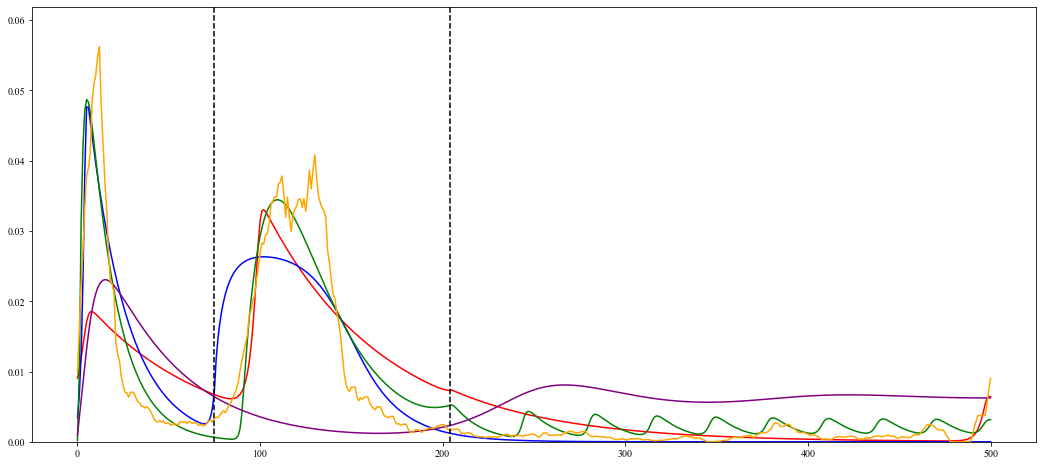

In [101]:
dates, I, R, D, V = owid.LoadCountryNormal("Australia")

measureDates = getCountryDates("Australia")
measureIndexes = []
for measure in measureDates:
    measureIndexes.append(getIndex(dates, measure))
measureIndexesAlt = measureIndexes.copy()
measureIndexesAlt.append(len(I))

consts = [len(I), I[0], max(I), measureIndexesAlt]

auParams = gdm.getParams(I, consts, randomIterCount=80, method = "Nelder-Mead")

auParamsB1 = gdm.getParamsB1(I, consts, randomIterCount=80, method = "Nelder-Mead") #with b1
auParamsB2 = gdm.getParamsB2(I, consts, randomIterCount=80, method = "Nelder-Mead") #with b2
auParamsG0 = gdm.getParamsG0(I, consts, randomIterCount=80, method = "Nelder-Mead") #with b2

fig,ax = plt.subplots(figsize=(18,8))
ax.plot(gdm.simFuncB1(auParamsB1, consts), color="red")
ax.plot(gdm.simFuncB2(auParamsB2, consts), color="blue")
ax.plot(gdm.simFuncG0(auParamsG0, consts), color="green")
ax.plot(gdm.simFunc(itParams, consts), color="purple")
ax.plot(I, color="orange")
ax.set_ylim([0, max(I)*1.1])

print(auParamsB1)
print(auParamsB2)
print(auParamsG0)
print(auParams)

for measure in measureDates:
    if(getIndex(dates,measure) != -1):
            plt.axvline(x=getIndex(dates, measure), color="black", linestyle='--')

## Canada

..\Models\GradDescModels.py:50: RuntimeWarning: invalid value encountered in double_scalars
  diffA = (beta[0]/ (1 + (beta[1]*I[t])**(beta[2]) ) )*A[t] - gamma0*A[t]


0 New best error:  1.0809269991006683e-05
1 New best error:  9.993707548410284e-06
4 New best error:  9.106477820578559e-06
5 New best error:  9.0983991071596e-06
7 New best error:  7.4756314087411806e-06
15 New best error:  7.3809915868561884e-06


..\Models\GradDescModels.py:164: RuntimeWarning: invalid value encountered in double_scalars
  diffA = (b0/ (1 + (currB1*I[t])**(b2) ) )*A[t] - gamma0*A[t]


0 New best error:  7.908808236108667e-06
1 New best error:  4.625885483848375e-06
8 New best error:  4.473434323843278e-06
0 New best error:  8.058582617672739e-06


..\Models\GradDescModels.py:280: RuntimeWarning: invalid value encountered in double_scalars
  diffA = (b0/ (1 + (b1*I[t])**(currB2) ) )*A[t] - gamma0*A[t]


1 New best error:  5.728668904574399e-06
2 New best error:  4.023111140768187e-06
5 New best error:  4.001094339749791e-06
12 New best error:  3.934106882738299e-06
26 New best error:  3.8085101117813836e-06


..\Models\GradDescModels.py:393: RuntimeWarning: invalid value encountered in double_scalars
  diffA = (b0/ (1 + (b1*I[t])**(b2) ) )*A[t] - currG0*A[t]


0 New best error:  5.504402247929633e-06
1 New best error:  4.9111181478814955e-06
4 New best error:  4.496428232844809e-06
18 New best error:  4.4052544101654116e-06
34 New best error:  4.1263250982945565e-06
42 New best error:  3.947129843474848e-06
[1.59301367e-03 7.59151156e-04 6.94579129e-01 3.37076680e-02
 4.08756091e-02 7.87907216e-01 1.95235693e+02 4.28289914e+01
 1.37041272e+02 9.16747887e+01 4.46864330e+00]
[ 1.40886461e-04  1.62415366e-03  2.54356815e-01  4.92644630e-03
  2.15137353e-02  5.03215677e-01  1.17201741e+02  3.99768936e+00
  5.44712010e+00  2.36819395e-01 -4.65743639e-01]
[ 2.92573846e-03  8.50673029e-04 -1.37444041e-01  1.55232568e-01
  2.94577088e-01  3.05086317e-01  3.36123593e-04  3.16079040e-02
  3.14467813e-01  8.87527973e+01  7.07815681e+00]
[3.42508805e-06 1.21749898e-12 9.01709290e-01 5.33571342e-03
 1.00928454e-02 1.44212716e+00 8.80382457e+01 7.84582085e-01]


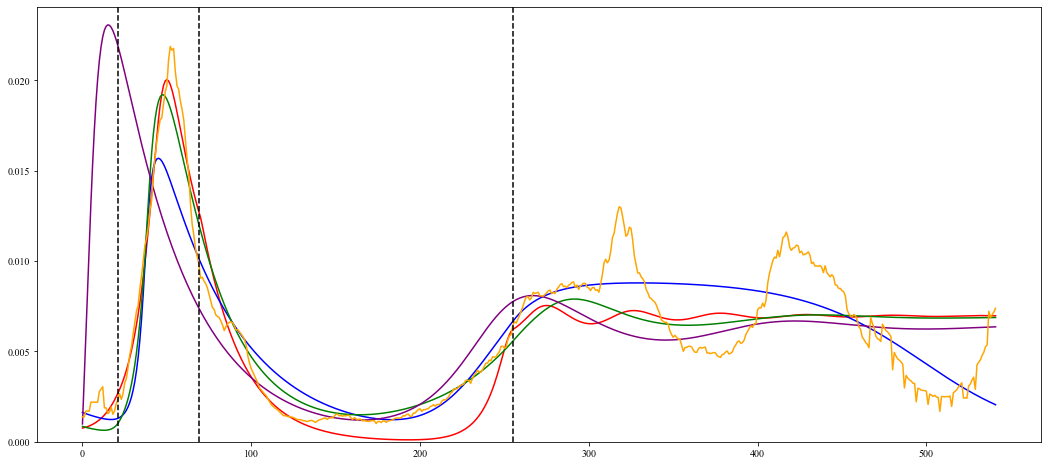

In [102]:
dates, I, R, D, V = owid.LoadCountryNormal("Canada")

measureDates = getCountryDates("Canada")
measureIndexes = []
for measure in measureDates:
    measureIndexes.append(getIndex(dates, measure))
measureIndexesAlt = measureIndexes.copy()
measureIndexesAlt.append(len(I))

consts = [len(I), I[0], max(I), measureIndexesAlt]

caParams = gdm.getParams(I, consts, randomIterCount=80, method = "Nelder-Mead")

caParamsB1 = gdm.getParamsB1(I, consts, randomIterCount=80, method = "Nelder-Mead") #with b1
caParamsB2 = gdm.getParamsB2(I, consts, randomIterCount=80, method = "Nelder-Mead") #with b2
caParamsG0 = gdm.getParamsG0(I, consts, randomIterCount=80, method = "Nelder-Mead") #with b2

fig,ax = plt.subplots(figsize=(18,8))
ax.plot(gdm.simFuncB1(caParamsB1, consts), color="red")
ax.plot(gdm.simFuncB2(caParamsB2, consts), color="blue")
ax.plot(gdm.simFuncG0(caParamsG0, consts), color="green")
ax.plot(gdm.simFunc(itParams, consts), color="purple")
ax.plot(I, color="orange")
ax.set_ylim([0, max(I)*1.1])

print(caParamsB1)
print(caParamsB2)
print(caParamsG0)
print(caParams)

for measure in measureDates:
    if(getIndex(dates,measure) != -1):
            plt.axvline(x=getIndex(dates, measure), color="black", linestyle='--')

## Write/Read fit parameters

In [120]:
import csv


outputFile = open('..\\..\\Data\\AIRD fits\\fitsMeasures.csv', 'w', newline='')
writer = csv.writer(outputFile)

row = californiaParams.tolist()
row.insert(0, "California")
writer.writerow(row)

row = californiaParamsB1.tolist()
row.insert(0, "California beta1")
writer.writerow(row)

row = californiaParamsB2.tolist()
row.insert(0, "California beta2")
writer.writerow(row)

row = californiaParamsG0.tolist()
row.insert(0, "California gamma0")
writer.writerow(row)


row = ukParams.tolist()
row.insert(0, "United Kingdom")
writer.writerow(row)

row = ukParamsB1.tolist()
row.insert(0, "United Kingdom beta1")
writer.writerow(row)

row = ukParamsB2.tolist()
row.insert(0, "United Kingdom beta2")
writer.writerow(row)

row = ukParamsG0.tolist()
row.insert(0, "United Kingdom gamma0")
writer.writerow(row)



row = itParams.tolist()
row.insert(0, "Italy")
writer.writerow(row)

row = itParamsB1.tolist()
row.insert(0, "Italy beta1")
writer.writerow(row)

row = itParamsB2.tolist()
row.insert(0, "Italy beta2")
writer.writerow(row)

row = itParamsG0.tolist()
row.insert(0, "Italy gamma0")
writer.writerow(row)


row = auParams.tolist()
row.insert(0, "Australia")
writer.writerow(row)

row = auParamsB1.tolist()
row.insert(0, "Australia beta1")
writer.writerow(row)

row = auParamsB2.tolist()
row.insert(0, "Australia beta2")
writer.writerow(row)

row = auParamsG0.tolist()
row.insert(0, "Australia gamma0")
writer.writerow(row)


row = caParams.tolist()
row.insert(0, "Canada")
writer.writerow(row)

row = caParamsB1.tolist()
row.insert(0, "Canada beta1")
writer.writerow(row)

row = caParamsB2.tolist()
row.insert(0, "Canada beta2")
writer.writerow(row)

row = caParamsG0.tolist()
row.insert(0, "Canada gamma0")
writer.writerow(row)


outputFile.close()

In [4]:
import csv

inputFile = open('..\\..\\Data\\AIRD fits\\fitsMeasures.csv', 'r')
rd = csv.reader(inputFile, delimiter=',') #reader

fitDict = {}
for row in rd:
    fitDict[row[0]] = list(map(float, row[1:]))
    
inputFile.close()

Start: 0.8251087422013439 80.02992191630855 0.887445675448088
2020-03-19 1 0.8251087422013439 93.52472196238566 0.887445675448088
2020-06-18 92 0.8251087422013439 73.99835315352044 0.887445675448088
2020-08-28 163 0.8251087422013439 117.73312125457977 0.887445675448088
2020-11-27 254 0.8251087422013439 41.13832224303296 0.887445675448088
2021-01-25 313 0.8251087422013439 286.30350984671577 0.887445675448088
2021-06-15 454 0.8251087422013439 198.44111490632952 0.887445675448088
2021-07-15 484 0.8251087422013439 126.69601407237445 0.887445675448088


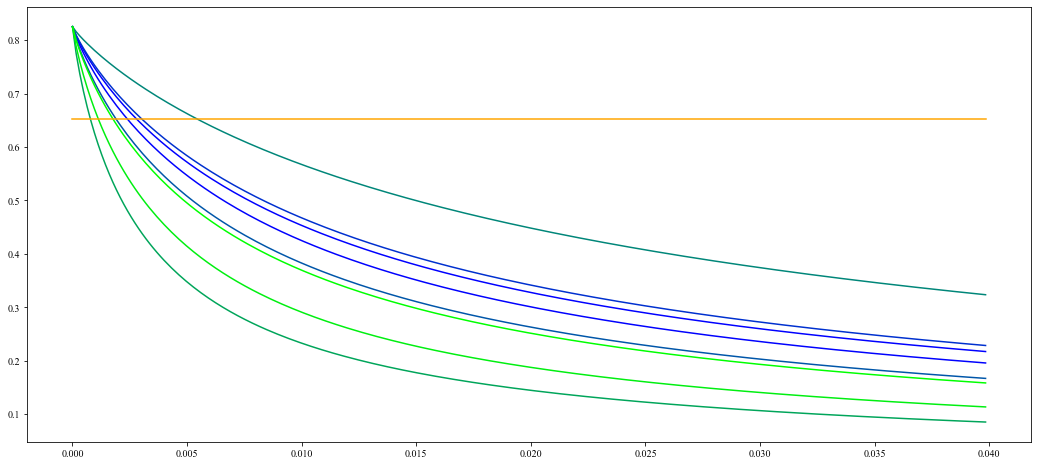

In [119]:
def getBeta(beta, x):
    return beta[0] / (1 + (beta[1] * x)**beta[2])

measureDates = getCountryDates("California Closure Data", filePathOver="../../Data/California Test Data/")

measureIndexes = []
for measure in measureDates:
    measureIndexes.append(getIndex(dates, measure))
measureIndexesAlt = measureIndexes.copy()
measureIndexesAlt.insert(0,0) #insert a 0 at the beginning


fig, ax = plt.subplots(figsize=(18,8))

end = .04
resol = 250
x = np.arange(0, end, end/resol)

#A(0), I(0), g0, g1, nu, b0, b1, b2
b0 = californiaParamsB1[5]
b1 = californiaParamsB1[6:-1]
b2 = californiaParamsB1[-1]

endColor = (0,0,1) #green
startColor= (0,1,0) #blue
newColor=[0,0,0]
for i in range(0, len(b1)):
    if(i != 0):
        print(measureDates[i-1], measureIndexes[i-1], b0, b1[i], b2)
    else:
        print("Start:", b0, b1[i], b2)
    
    frac = measureIndexesAlt[i]/measureIndexesAlt[-1]
    for j in range(3):
        newColor[j] = (endColor[j]*(1-frac)+startColor[j]*frac)
    
    ax.plot(x, getBeta([b0, b1[i], b2], x), color=tuple(newColor))
    
    
ax.plot(x, californiaParamsB2[2]*np.ones(resol), color="orange")

2020-03-19 1 0.7588892075604381 42.90212386196308 1.3155633551576793
2020-06-18 92 0.7588892075604381 42.90212386196308 1.425329234886295
2020-08-28 163 0.7588892075604381 42.90212386196308 1.0860363760099263
2020-11-27 254 0.7588892075604381 42.90212386196308 3.494236713580311
2021-01-25 313 0.7588892075604381 42.90212386196308 0.570632626526586
2021-06-15 454 0.7588892075604381 42.90212386196308 1.0563435578493783
2021-07-15 484 0.7588892075604381 42.90212386196308 1.0034849178455385


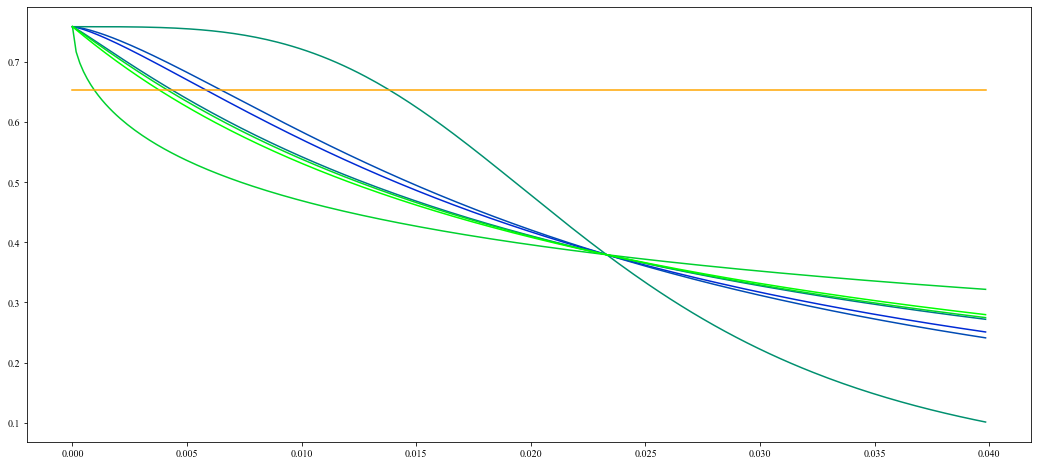

In [118]:
fig, ax = plt.subplots(figsize=(18,8))

end = .04
resol = 250
x = np.arange(0, end, end/resol)

#A(0), I(0), g0, g1, nu, b0, b1, b2
b0 = californiaParamsB2[5]
b1 = californiaParamsB2[6]
b2 = californiaParamsB2[7:]

startColor= (0,1,0)
endColor = (0,0,1)
newColor=[0,0,0]
for i in range(1, len(b2)):
    if(i != 0):
        print(measureDates[i-1], measureIndexes[i-1], b0, b1, b2[i])
    else:
        print("Start:", b0, b1, b2[i])
    
    frac = measureIndexesAlt[i]/measureIndexesAlt[-1]
    for j in range(3):
        newColor[j] = (endColor[j]*(1-frac)+startColor[j]*frac)
    
    ax.plot(x, getBeta([b0, b1, b2[i]], x), color=tuple(newColor))
    
ax.plot(x, californiaParamsB2[2]*np.ones(resol), color="orange")

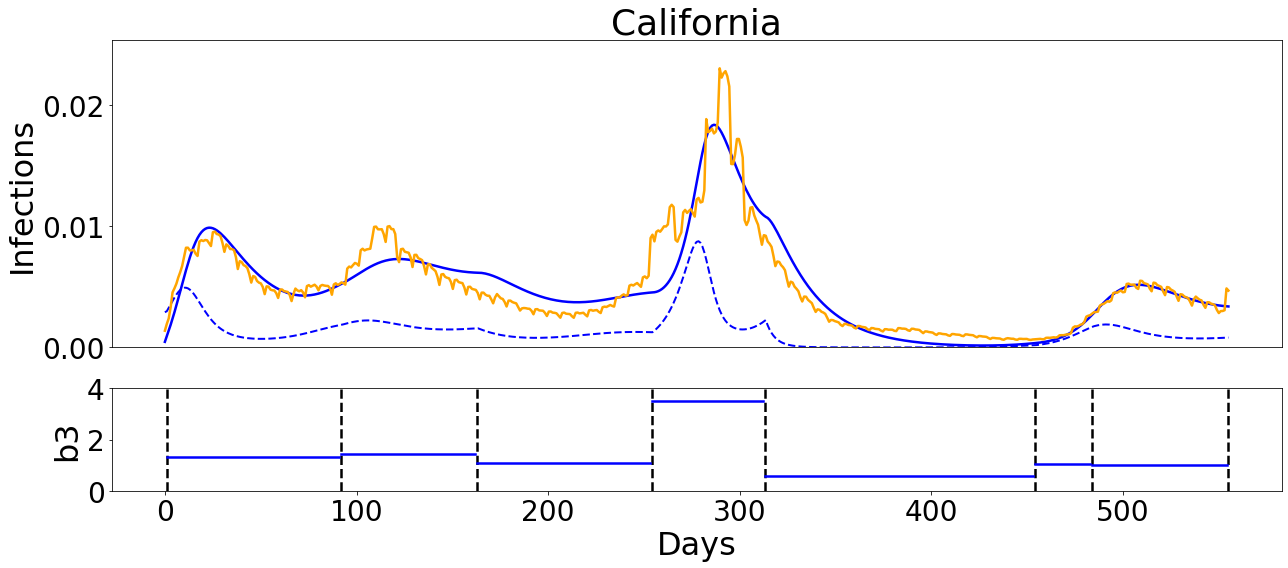

In [70]:

dates, I, R, D = loadCAData()
consts = [len(I), I[0], max(I), 0]

measureDates = getCountryDates("California Closure Data", filePathOver="../../Data/California Test Data/")
measureIndexes = []
for measure in measureDates:
    measureIndexes.append(getIndex(dates, measure))
measureIndexesAlt = measureIndexes.copy()
measureIndexesAlt.append(len(I))

californiaParamsB2 = fitDict["California beta2"]


consts = [len(I), I[0], max(I), measureIndexesAlt]
#californiaParams = gdm.getParams(I, consts, randomIterCount=80, method = "Nelder-Mead")
#californiaParamsB1 = gdm.getParamsB1(I, consts, randomIterCount=100, method = "Nelder-Mead") #with b1
#californiaParamsB2 = gdm.getParamsB2(I, consts, randomIterCount=100, method = "Nelder-Mead") #with b2
#californiaParamsG0 = gdm.getParamsG0(I, consts, randomIterCount=100, method = "Nelder-Mead") #with b2#

fig,ax = plt.subplots(2,1, figsize=(18,8), gridspec_kw={'height_ratios': [30, 10]})
#ax.plot(gdm.simFuncB1(californiaParamsB1, consts), color="red")

fitA, fitI = gdm.simFuncB2(californiaParamsB2, consts, giveA=True)
ax[0].plot(fitI, color="blue", linewidth=2.5)
ax[0].plot(fitA, color="blue", linewidth=2, linestyle="dashed")
#ax.plot(gdm.simFuncG0(californiaParamsG0, consts), color="green")
#ax[0].plot(gdm.simFunc(californiaParams, consts), color="purple")
ax[0].plot(I, color="orange", linewidth=2.5)
ax[0].set_ylim([0, max(I)*1.1])

for ind in measureIndexesAlt:
        plt.axvline(x=ind, color="black", linestyle='--', linewidth=2.5)
            
prevIndex=0      
for i in range(len(measureIndexesAlt)):
    currIndex = measureIndexesAlt[i]
    ax[1].plot(np.arange(prevIndex, currIndex, 1), californiaParamsB2[7+i]*np.ones(currIndex - prevIndex), color="blue", linewidth=2.5)
    prevIndex = currIndex
    
    
ax[0].set_title("California", fontsize=36)
ax[0].get_xaxis().set_visible(False)


ax[0].set_ylabel("Infections", fontsize=32)
ax[1].set_ylabel("b3", fontsize=32)
ax[1].set_xlabel("Days", fontsize=32)

ax[0].tick_params(axis='y', labelsize=28)
ax[1].tick_params(axis='y', labelsize=28)
ax[1].tick_params(axis='x', labelsize=28)

ax[1].set_yticks([0, 2, 4])

plt.tight_layout()

fig.subplots_adjust(hspace=.2)

#plt.savefig("Figures/CAB3Fit.jpeg", bbox_inches = 'tight')

[-0.16705011  0.11571582  0.15551091  0.07937993  0.26386444  0.03708573
  0.07206051  0.06315823]


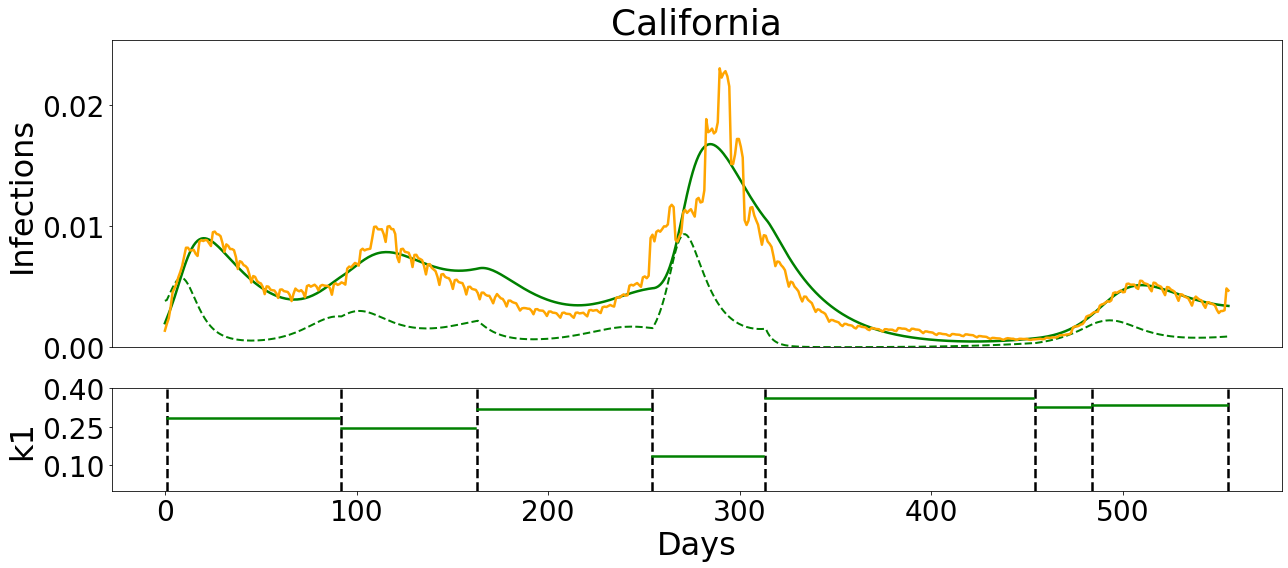

In [72]:
dates, I, R, D = loadCAData()
consts = [len(I), I[0], max(I), 0]

measureDates = getCountryDates("California Closure Data", filePathOver="../../Data/California Test Data/")
measureIndexes = []
for measure in measureDates:
    measureIndexes.append(getIndex(dates, measure))
measureIndexesAlt = measureIndexes.copy()
measureIndexesAlt.append(len(I))

californiaParamsG0 = fitDict["California gamma0"]


consts = [len(I), I[0], max(I), measureIndexesAlt]
#californiaParams = gdm.getParams(I, consts, randomIterCount=80, method = "Nelder-Mead")
#californiaParamsB1 = gdm.getParamsB1(I, consts, randomIterCount=100, method = "Nelder-Mead") #with b1
#californiaParamsB2 = gdm.getParamsB2(I, consts, randomIterCount=100, method = "Nelder-Mead") #with b2
#californiaParamsG0 = gdm.getParamsG0(I, consts, randomIterCount=100, method = "Nelder-Mead") #with b2#

fig,ax = plt.subplots(2,1, figsize=(18,8), gridspec_kw={'height_ratios': [30, 10]})

fitA, fitI = gdm.simFuncG0(californiaParamsG0, consts, giveA=True)
ax[0].plot(fitI, color="green", linewidth=2.5)
ax[0].plot(fitA, color="green", linewidth=2, linestyle="dashed")
#ax.plot(gdm.simFuncB1(californiaParamsB1, consts), color="red")
#ax[0].plot(gdm.simFuncG0(californiaParamsG0, consts), color="green", linewidth=2.5)
#ax.plot(gdm.simFuncG0(californiaParamsG0, consts), color="green")
#ax[0].plot(gdm.simFunc(californiaParams, consts), color="purple")
ax[0].plot(I, color="orange", linewidth=2.5)
ax[0].set_ylim([0, max(I)*1.1])

for ind in measureIndexesAlt:
        plt.axvline(x=ind, color="black", linestyle='--', linewidth=2.5)
            
prevIndex=0
beta0 = -1 * np.asarray(californiaParamsG0[2:2+len(measureIndexesAlt)])
beta0 = beta0 + .4
print(beta0)
for i in range(len(measureIndexesAlt)):
    currIndex = measureIndexesAlt[i]
    ax[1].plot(np.arange(prevIndex, currIndex, 1), californiaParamsG0[2+i]*np.ones(currIndex - prevIndex), color="green", linewidth=2.5)
    prevIndex = currIndex
    
    
ax[0].set_title("California", fontsize=36)
ax[0].get_xaxis().set_visible(False)


ax[0].set_ylabel("Infections", fontsize=32)
ax[1].set_ylabel("k1", fontsize=32)
ax[1].set_xlabel("Days", fontsize=32)

ax[0].tick_params(axis='y', labelsize=28)
ax[1].tick_params(axis='y', labelsize=28)
ax[1].tick_params(axis='x', labelsize=28)

ax[1].set_ylim([0,.4])
ax[1].set_yticks([.1, .25, .4])

plt.tight_layout()

fig.subplots_adjust(hspace=.2)

#plt.savefig("Figures/CAG0Fit.eps", bbox_inches = 'tight')

[-0.16705011  0.11571582  0.15551091  0.07937993  0.26386444  0.03708573
  0.07206051  0.06315823]


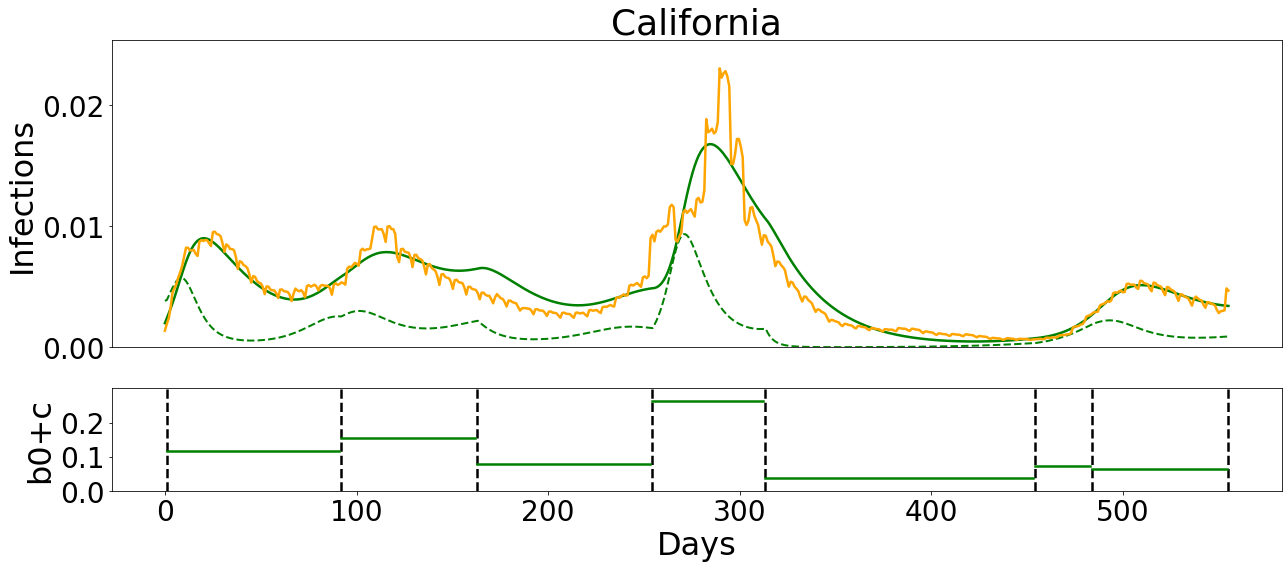

In [74]:
dates, I, R, D = loadCAData()
consts = [len(I), I[0], max(I), 0]

measureDates = getCountryDates("California Closure Data", filePathOver="../../Data/California Test Data/")
measureIndexes = []
for measure in measureDates:
    measureIndexes.append(getIndex(dates, measure))
measureIndexesAlt = measureIndexes.copy()
measureIndexesAlt.append(len(I))

californiaParamsG0 = fitDict["California gamma0"]


consts = [len(I), I[0], max(I), measureIndexesAlt]
#californiaParams = gdm.getParams(I, consts, randomIterCount=80, method = "Nelder-Mead")
#californiaParamsB1 = gdm.getParamsB1(I, consts, randomIterCount=100, method = "Nelder-Mead") #with b1
#californiaParamsB2 = gdm.getParamsB2(I, consts, randomIterCount=100, method = "Nelder-Mead") #with b2
#californiaParamsG0 = gdm.getParamsG0(I, consts, randomIterCount=100, method = "Nelder-Mead") #with b2#

fig,ax = plt.subplots(2,1, figsize=(18,8), gridspec_kw={'height_ratios': [30, 10]})
fitA, fitI = gdm.simFuncG0(californiaParamsG0, consts, giveA=True)
ax[0].plot(fitI, color="green", linewidth=2.5)
ax[0].plot(fitA, color="green", linewidth=2, linestyle="dashed")
#ax.plot(gdm.simFuncB1(californiaParamsB1, consts), color="red")
#ax[0].plot(gdm.simFuncG0(californiaParamsG0, consts), color="green", linewidth=2.5)
#ax.plot(gdm.simFuncG0(californiaParamsG0, consts), color="green")
#ax[0].plot(gdm.simFunc(californiaParams, consts), color="purple")
ax[0].plot(I, color="orange", linewidth=2.5)
ax[0].set_ylim([0, max(I)*1.1])

for ind in measureIndexesAlt:
        plt.axvline(x=ind, color="black", linestyle='--', linewidth=2.5)
            
prevIndex=0
beta0 = -1 * np.asarray(californiaParamsG0[2:2+len(measureIndexesAlt)])
beta0 = beta0 + .4
print(beta0)
for i in range(len(measureIndexesAlt)):
    currIndex = measureIndexesAlt[i]
    ax[1].plot(np.arange(prevIndex, currIndex, 1), beta0[i]*np.ones(currIndex - prevIndex), color="green", linewidth=2.5)
    prevIndex = currIndex
    
    
ax[0].set_title("California", fontsize=36)
ax[0].get_xaxis().set_visible(False)


ax[0].set_ylabel("Infections", fontsize=32)
ax[1].set_ylabel("b0+c", fontsize=32)
ax[1].set_xlabel("Days", fontsize=32)

ax[0].tick_params(axis='y', labelsize=28)
ax[1].tick_params(axis='y', labelsize=28)
ax[1].tick_params(axis='x', labelsize=28)

ax[1].set_ylim([0,.3])
ax[1].set_yticks([0, .1, .2])

plt.tight_layout()

fig.subplots_adjust(hspace=.2)

#plt.savefig("Figures/CAG0AltFit.eps", bbox_inches = 'tight')

80.02992191630855
93.52472196238566
73.99835315352044
117.73312125457977
41.13832224303296
286.30350984671577
198.44111490632952
126.69601407237445


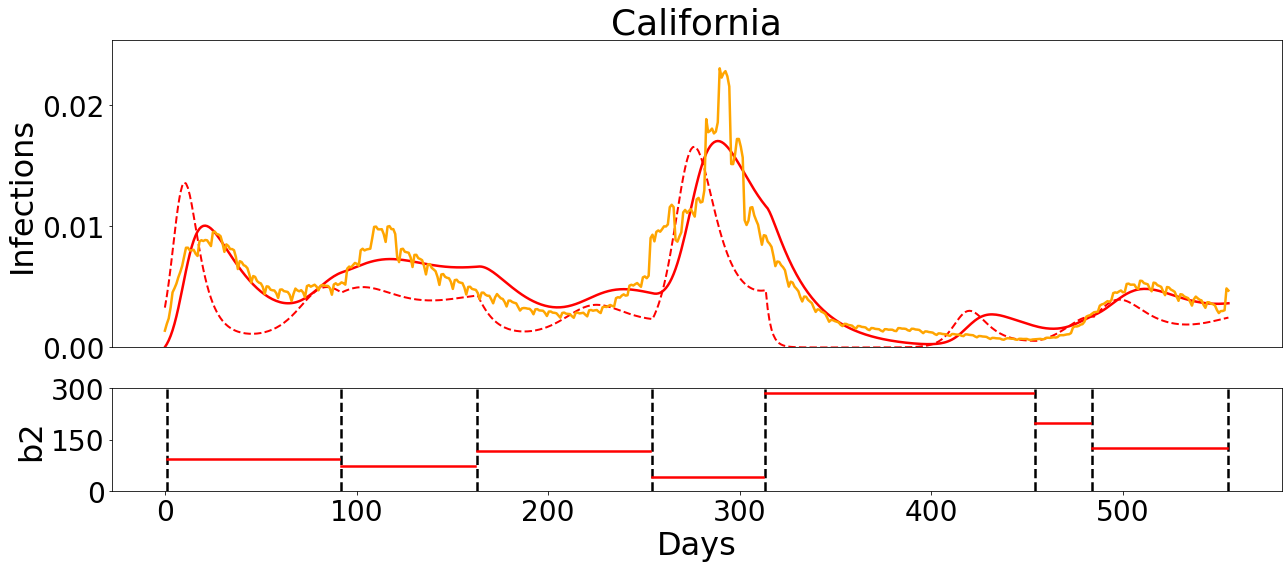

In [77]:

dates, I, R, D = loadCAData()
consts = [len(I), I[0], max(I), 0]

measureDates = getCountryDates("California Closure Data", filePathOver="../../Data/California Test Data/")
measureIndexes = []
for measure in measureDates:
    measureIndexes.append(getIndex(dates, measure))
measureIndexesAlt = measureIndexes.copy()
measureIndexesAlt.append(len(I))

californiaParamsB1 = fitDict["California beta1"]


consts = [len(I), I[0], max(I), measureIndexesAlt]
#californiaParams = gdm.getParams(I, consts, randomIterCount=80, method = "Nelder-Mead")
#californiaParamsB1 = gdm.getParamsB1(I, consts, randomIterCount=100, method = "Nelder-Mead") #with b1
#californiaParamsB2 = gdm.getParamsB2(I, consts, randomIterCount=100, method = "Nelder-Mead") #with b2
#californiaParamsG0 = gdm.getParamsG0(I, consts, randomIterCount=100, method = "Nelder-Mead") #with b2#

fig,ax = plt.subplots(2,1, figsize=(18,8), gridspec_kw={'height_ratios': [30, 10]})

fitA, fitI = gdm.simFuncB1(californiaParamsB1, consts, giveA=True)
ax[0].plot(fitI, color="red", linewidth=2.5)
ax[0].plot(fitA, color="red", linewidth=2, linestyle="dashed")

#ax[0].plot(gdm.simFuncB1(californiaParamsB1, consts), color="red", linewidth=2.5)
#ax[0].plot(gdm.simFuncB2(californiaParamsB2, consts), color="blue", linewidth=2.5)
#ax.plot(gdm.simFuncG0(californiaParamsG0, consts), color="green")
#ax[0].plot(gdm.simFunc(californiaParams, consts), color="purple")
ax[0].plot(I, color="orange", linewidth=2.5)
ax[0].set_ylim([0, max(I)*1.1])

for ind in measureIndexesAlt:
        plt.axvline(x=ind, color="black", linestyle='--', linewidth=2.5)
            
prevIndex=0      
for i in range(len(measureIndexesAlt)):
    currIndex = measureIndexesAlt[i]
    ax[1].plot(np.arange(prevIndex, currIndex, 1), californiaParamsB1[6+i]*np.ones(currIndex - prevIndex), color="red", linewidth=2.5)
    print(californiaParamsB1[6+i])
    prevIndex = currIndex
    
    
ax[0].set_title("California", fontsize=36)
ax[0].get_xaxis().set_visible(False)


ax[0].set_ylabel("Infections", fontsize=32)
ax[1].set_ylabel("b2", fontsize=32)
ax[1].set_xlabel("Days", fontsize=32)

ax[0].tick_params(axis='y', labelsize=28)
ax[1].tick_params(axis='y', labelsize=28)
ax[1].tick_params(axis='x', labelsize=28)

ax[1].set_yticks([0, 150, 300])

plt.tight_layout()

fig.subplots_adjust(hspace=.2)

#plt.savefig("Figures/CAB2Fit.eps", bbox_inches = 'tight')